In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline


# Blind source separation using NMF

Toy example using two sinusoidal signals


In [3]:
print(__doc__)

import os as os
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
from scipy.signal import stft, istft, spectrogram, chirp, butter, lfilter, freqz
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from numpy import linalg


Automatically created module for IPython interactive environment


In [4]:
plt.rcParams['figure.figsize'] = (12.0, 9.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rc('text', usetex=True)
plt.rc('font', family='times')
plt.rcParams.update({'font.size': 26})

In [31]:
figPath = './figs-01-16/'
fs = int(10e6)
f1 = 3e6
f2 = 1e6
secondsOfData = 0.01
numberOfSamples = int(secondsOfData*fs)
nfft = 256
nperseg = 256
beta_loss = 'kullback-leibler'
save_fig = False
exp_name = '2wide'

In [6]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Generate and mix signals

In [7]:
t = np.linspace(0, secondsOfData, numberOfSamples)
signal1 = np.sin(2*np.pi*f1*t)
signal1 = np.concatenate((signal1, np.zeros(signal1.shape[0]//3)))

signal2 = np.sin(2*np.pi*f2*t)
# signal2 = chirp(t, 1e6, 0.1, 2e6)

signal2 = np.concatenate((np.zeros(signal2.shape[0]//4), signal2))
signal2 = np.concatenate((signal2, np.zeros(signal1.shape[0] - signal2.shape[0])))

signal3 = np.sin(2*np.pi*1.5*f2*t)
signal3 = np.concatenate((np.zeros(signal2.shape[0]//2), 
                          signal3[:(signal2.shape[0]-signal2.shape[0]//2 - 40000)], 
                          np.zeros(40000)))

data = signal1+signal2 #Mixing signals
data.shape

(133333,)

In [8]:
signal1 = np.zeros(numberOfSamples)
signal2 = np.zeros(numberOfSamples)
signal3 = np.zeros(numberOfSamples)

t = np.linspace(0, secondsOfData/2, numberOfSamples/2)

signal1[:-1 - numberOfSamples//2+1] = np.sin(2*np.pi*f1*t)
signal2[(numberOfSamples//2+1)//4:-1 - numberOfSamples//2+1 + (numberOfSamples//2+1)//4] = np.sin(2*np.pi*f2*t)
signal3[numberOfSamples//2-10000:-1-10000+1] = np.sin(2*np.pi*1.5*f2*t)

# signal1 = np.sin(2*np.pi*f1*t)
# signal1 = np.concatenate((signal1, np.zeros(signal1.shape[0]//3)))

# signal2 = np.sin(2*np.pi*f2*t)
# # signal2 = chirp(t, 1e6, 0.1, 2e6)

# signal2 = np.concatenate((np.zeros(signal2.shape[0]//4), signal2))
# signal2 = np.concatenate((signal2, np.zeros(signal1.shape[0] - signal2.shape[0])))

# signal3 = np.sin(2*np.pi*1.5*f2*t)
# signal3 = np.concatenate((np.zeros(signal2.shape[0]//2), 
#                           signal3[:(signal2.shape[0]-signal2.shape[0]//2 - 40000)], 
#                           np.zeros(40000)))

data = signal1+signal2+signal3 #Mixing signals
data = data*np.sqrt(1/np.var(data))
# data.shape

/home/felipe/miniconda3/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """


In [9]:
t = np.linspace(0, secondsOfData, numberOfSamples)
signal1 = np.exp(1j*2*np.pi*f1*t)
signal2 = np.exp(1j*2*np.pi*f2*t)
signal1 = np.concatenate((signal1, np.zeros(signal1.shape[0]//4)))
signal2 = np.concatenate((np.zeros(signal2.shape[0]//4), signal2))
data = signal1+signal2
data = data*np.sqrt(1/np.var(data))


# chirp1sin Experiment data

In [10]:
t = np.linspace(0, secondsOfData, numberOfSamples)
signal1 = np.sin(2*np.pi*f1*t)
signal1 = np.concatenate((signal1, np.zeros(np.round(signal1.shape[0]/1.2).astype(int))))
signal2 = chirp(t, f2, secondsOfData, 1.2*f2)
signal2 = np.concatenate((np.zeros(np.round(signal2.shape[0]/1.2).astype(int)), signal2))
data = signal1+signal2
data = data*np.sqrt(1/np.var(data))

# 2chirp Experiment data


In [11]:
t = np.linspace(0, secondsOfData, numberOfSamples)
signal1 = chirp(t, f1, secondsOfData, f1*1.2)
signal1 = np.concatenate((signal1, np.zeros(np.round(signal1.shape[0]/1.2).astype(int))))
signal2 = chirp(t, f2, secondsOfData, 1.2*f2)
signal2 = np.concatenate((np.zeros(np.round(signal2.shape[0]/1.2).astype(int)), signal2))
data = signal1+signal2
data = data*np.sqrt(1/np.var(data))

# 2wide Experiment data


In [12]:
# t = np.linspace(0, secondsOfData, numberOfSamples)
# signal1 = np.random.randn(numberOfSamples)
# lowcut = 1e6
# highcut = 1.1e6
# signal1 = butter_bandpass_filter(signal1, lowcut, highcut, fs, order=6)
# signal1 = np.concatenate((signal1, np.zeros(np.round(signal1.shape[0]/1.2).astype(int))))
# signal2 = np.random.randn(numberOfSamples)
# lowcut = 1.09e6
# highcut = 1.19e6
# signal2 = butter_bandpass_filter(signal2, lowcut, highcut, fs, order=6)
# signal2 = np.concatenate((np.zeros(np.round(signal2.shape[0]/1.2).astype(int)), signal2))
# data = signal1+signal2
# data = data*np.sqrt(1/np.var(data))
# w, h = freqz(signal1, 1)
# plt.plot((fs * 0.5 / np.pi) * w, 10*np.log10(abs(h)))
# w, h = freqz(signal2, 1)
# plt.plot((fs * 0.5 / np.pi) * w, 10*np.log10(abs(h)), color='red')

/home/felipe/miniconda3/envs/python3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['times'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


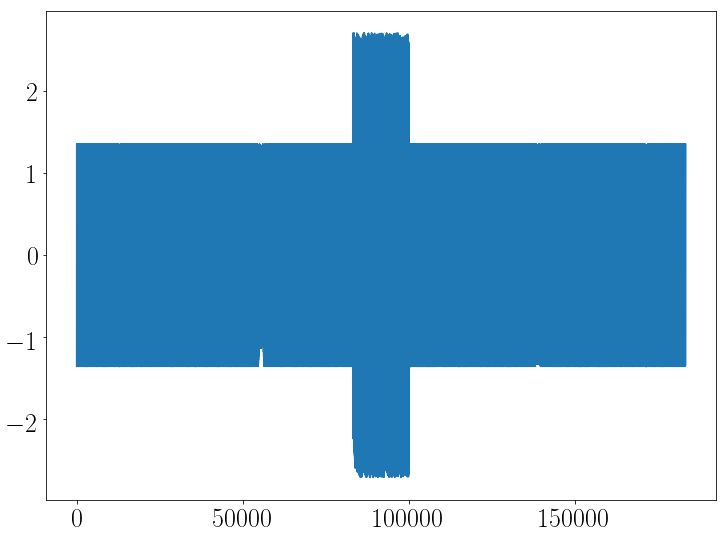

In [13]:
plt.figure()
plt.plot(data)
plt.show()

In [14]:
def plotSpectrogram(f, t, Sxx, vmin=None, vmax=None, save_fig=False, fig_path=None, figName=None):
    specdB = 10*np.log10(np.abs(Sxx))    
    cmap = plt.get_cmap('jet')
    
    if vmin==None and vmax==None:
        vmin = np.min(specdB)
        vmax = np.max(specdB)       
        
    plt.pcolormesh(t*1e3, f/1e6, specdB, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.ylabel('Frequency [MHz]')
    plt.xlabel('Time [ms]')
    plt.colorbar().ax.set_ylabel('[dB]')
    plt.tight_layout()
    if save_fig:
        if not os.path.exists(fig_path):
            os.makedirs(fig_path)
        figName = ''.join([figName, '.eps'])
        plt.savefig(os.path.join(fig_path,figName), dpi=100, format='eps')
    plt.show()

In [15]:
def saveFig(fig, fig_path, fig_name, save_fig=False):
    if save_fig:
        if not os.path.exists(fig_path):
            os.makedirs(fig_path)
        fig_name = ''.join([fig_name, '.eps'])
        fig.savefig(os.path.join(fig_path, fig_name), dpi=100, format='eps')

In [32]:
f, t, Zxx = stft(data, fs=fs, nperseg=nperseg, nfft=nfft, boundary=None)
inputNMF = np.abs(Zxx)
inputNMF = np.where(inputNMF==0, 1e-12, inputNMF)

# NMF's Input

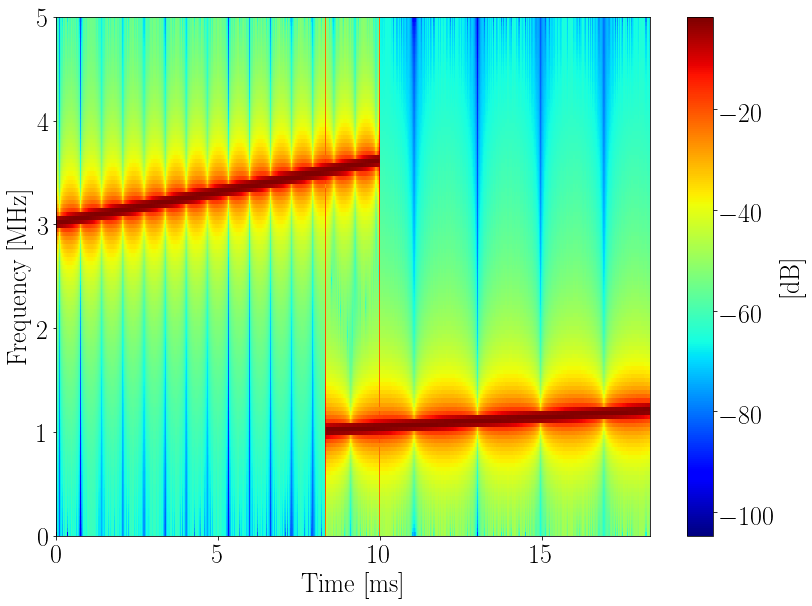

In [33]:
specdB = 10*np.log10(inputNMF)    
cmap = plt.get_cmap('jet')
vmin = np.min(specdB)
vmax = np.max(specdB)
fig = plt.figure()
ax = fig.add_subplot(111)
v = ax.pcolormesh(t*1e3, f/1e6, specdB, vmin=vmin, vmax=vmax, cmap=cmap)
ax.set_ylabel('Frequency [MHz]')
ax.set_xlabel('Time [ms]')
fig.colorbar(v).ax.set_ylabel('[dB]')
plt.tight_layout()
saveFig(fig, figPath, ''.join(['spec_input_', exp_name]), save_fig=save_fig)
plt.show()

In [18]:
inputNMF.shape

(513, 358)

In [37]:
model = NMF(init='nndsvda', max_iter=10000, verbose=2, random_state=1, tol=1e-16, 
              beta_loss=beta_loss, n_components=5, solver='mu')
W = model.fit_transform(inputNMF)
H = model.components_

Epoch 10 reached after 0.028 seconds, error: 47.703661
Epoch 20 reached after 0.051 seconds, error: 47.623638
Epoch 30 reached after 0.069 seconds, error: 47.576719
Epoch 40 reached after 0.086 seconds, error: 47.568662
Epoch 50 reached after 0.102 seconds, error: 47.567258
Epoch 60 reached after 0.119 seconds, error: 47.566568
Epoch 70 reached after 0.135 seconds, error: 47.565824
Epoch 80 reached after 0.151 seconds, error: 47.565413
Epoch 90 reached after 0.168 seconds, error: 47.565102
Epoch 100 reached after 0.184 seconds, error: 47.564783
Epoch 110 reached after 0.201 seconds, error: 47.564396
Epoch 120 reached after 0.218 seconds, error: 47.563865
Epoch 130 reached after 0.238 seconds, error: 47.563033
Epoch 140 reached after 0.262 seconds, error: 47.561475
Epoch 150 reached after 0.280 seconds, error: 47.557692
Epoch 160 reached after 0.298 seconds, error: 47.543172
Epoch 170 reached after 0.314 seconds, error: 47.369323
Epoch 180 reached after 0.330 seconds, error: 45.337581
E

# Spectrogram of the Output of NMF

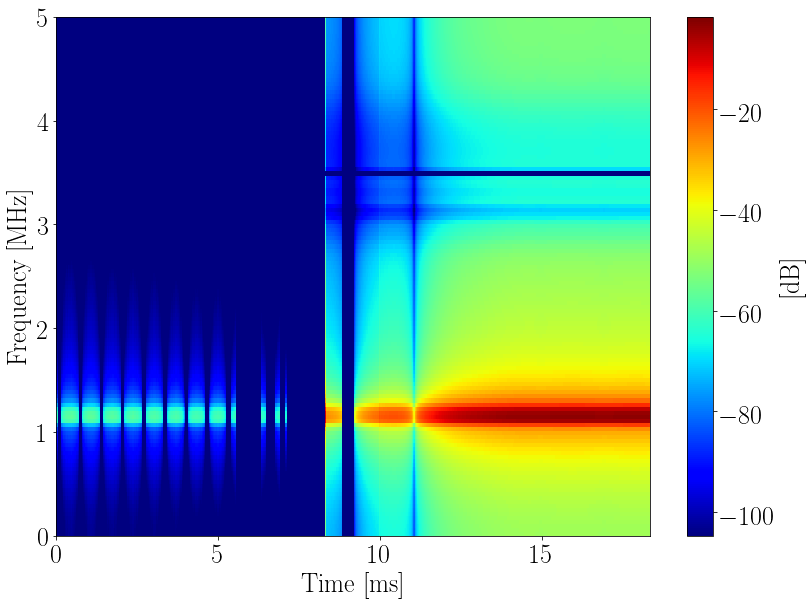

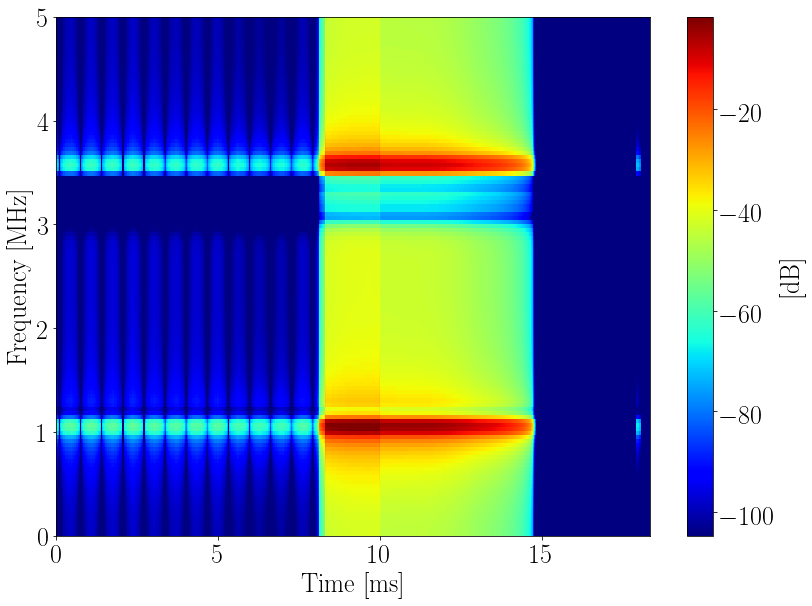

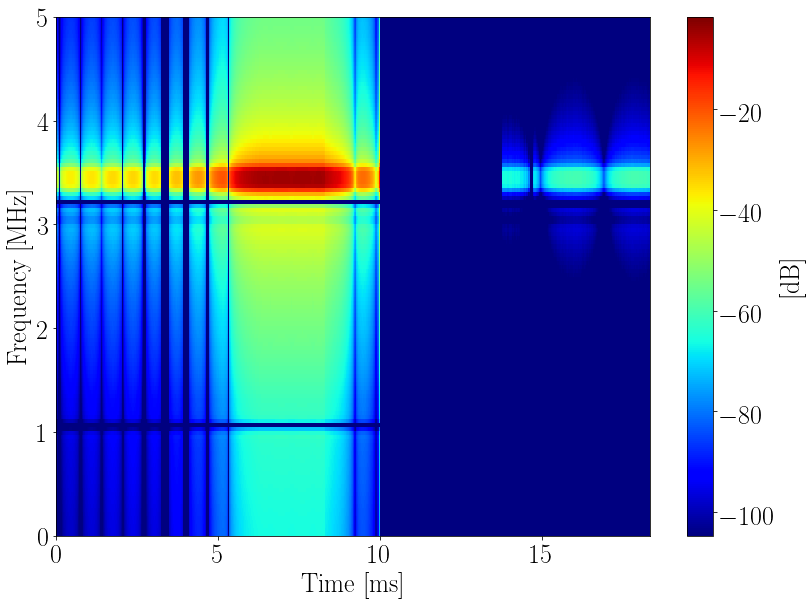

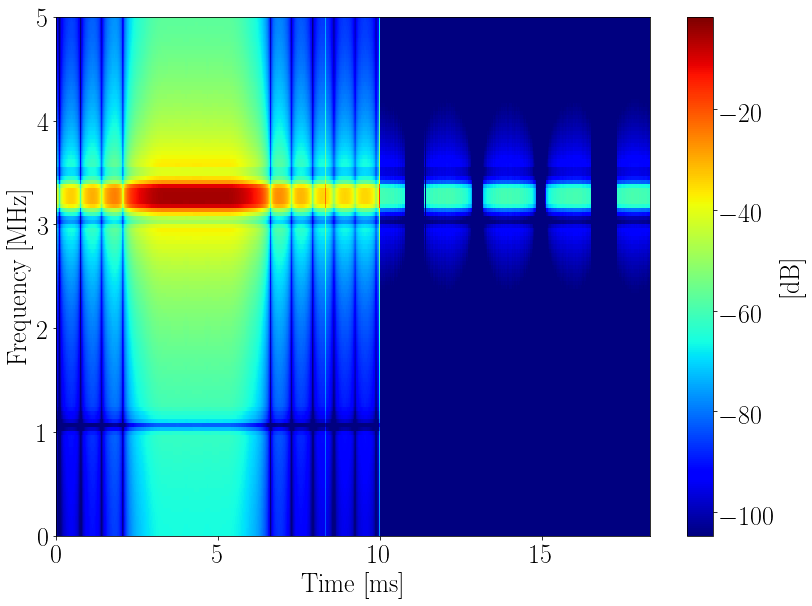

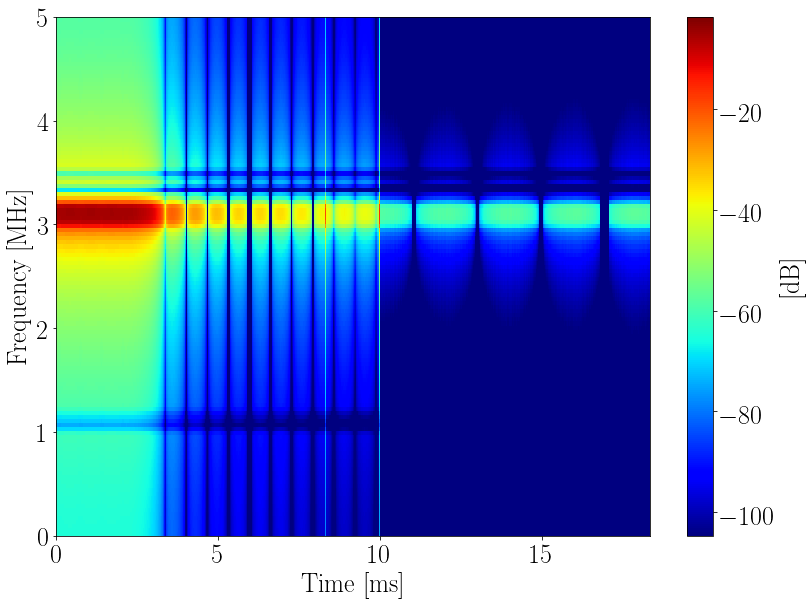

In [38]:
numberOfSources = W.shape[1]
for i in range(numberOfSources):
    signal = np.outer(W[:,i],H[i,:])
    signal = np.where(signal==0, 1e-12, signal)
    plotSpectrogram(f, t, signal, vmin=vmin, vmax=vmax, 
                    save_fig=save_fig, fig_path=figPath, figName=''.join(['spec_output_', exp_name,
                                                                          beta_loss, str(i)]))

# Basis Vectors

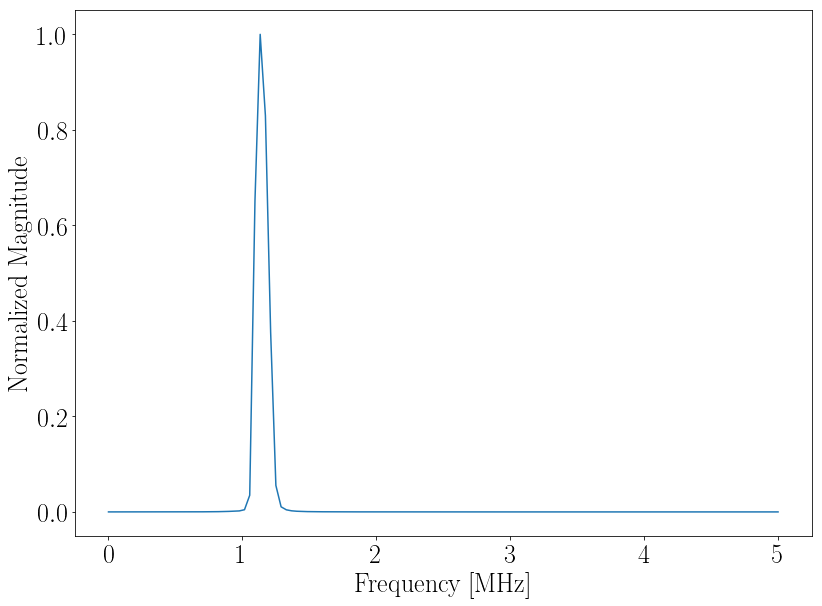

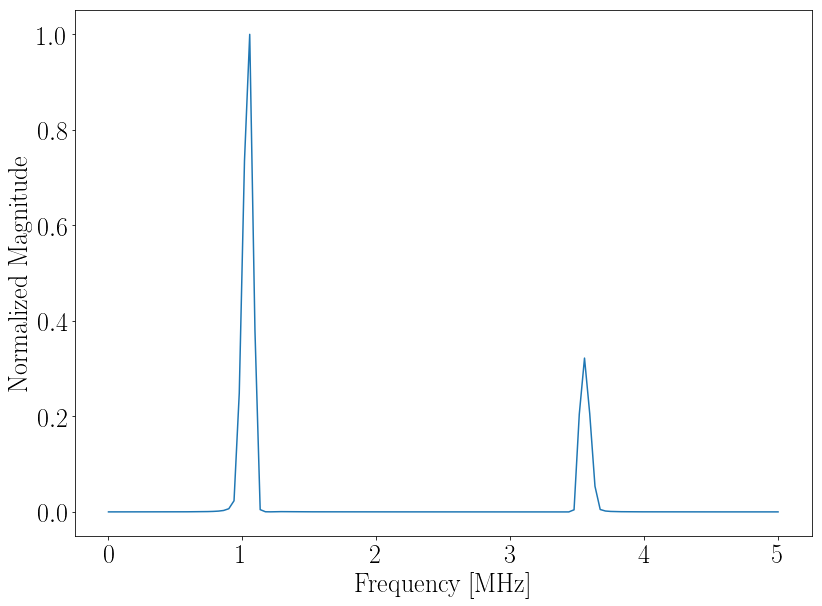

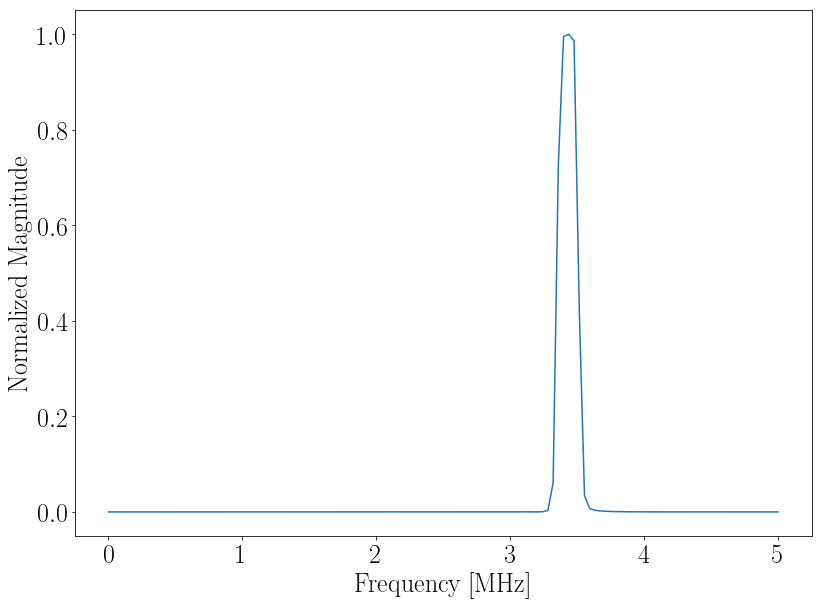

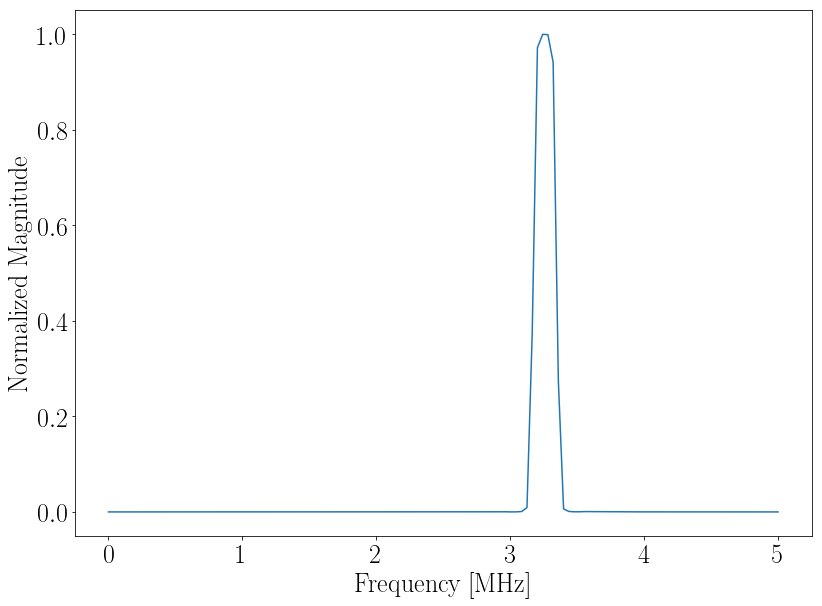

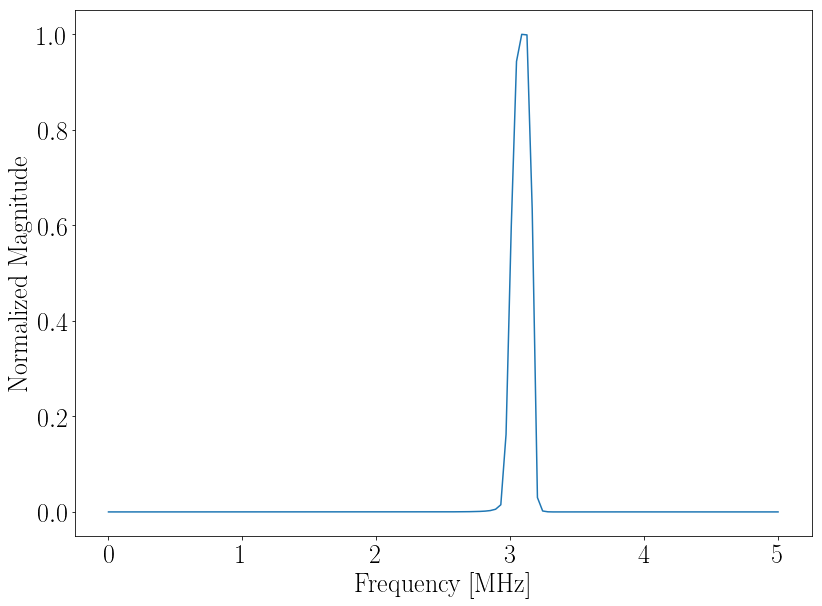

In [39]:
for i in range(W.shape[1]):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(f/1e6, W[:,i]/np.max(W[:,i]))
    ax.set_xlabel('Frequency [MHz]')
    ax.set_ylabel('Normalized Magnitude')
    fig.tight_layout()
    saveFig(fig, figPath, ''.join(['basis_', exp_name, beta_loss, str(i)]), save_fig=save_fig)
    plt.show()

# Activation Vectors


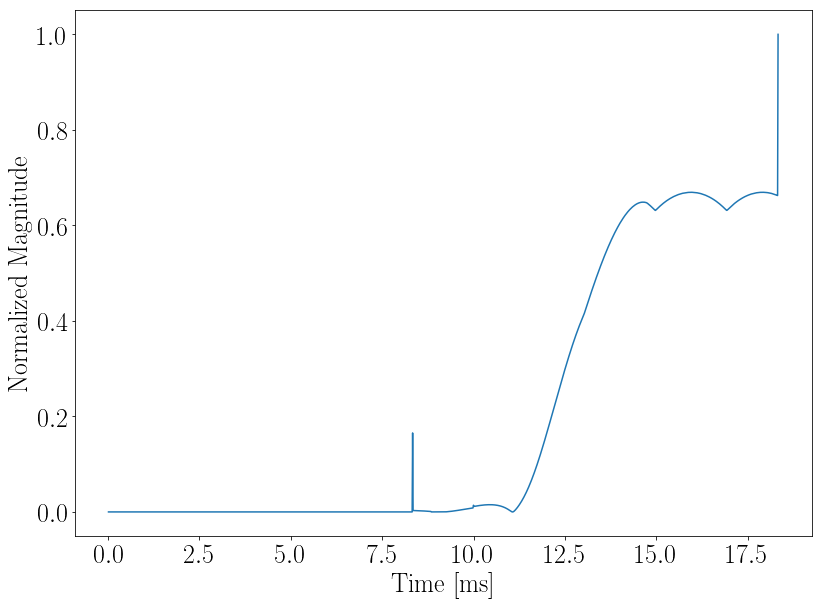

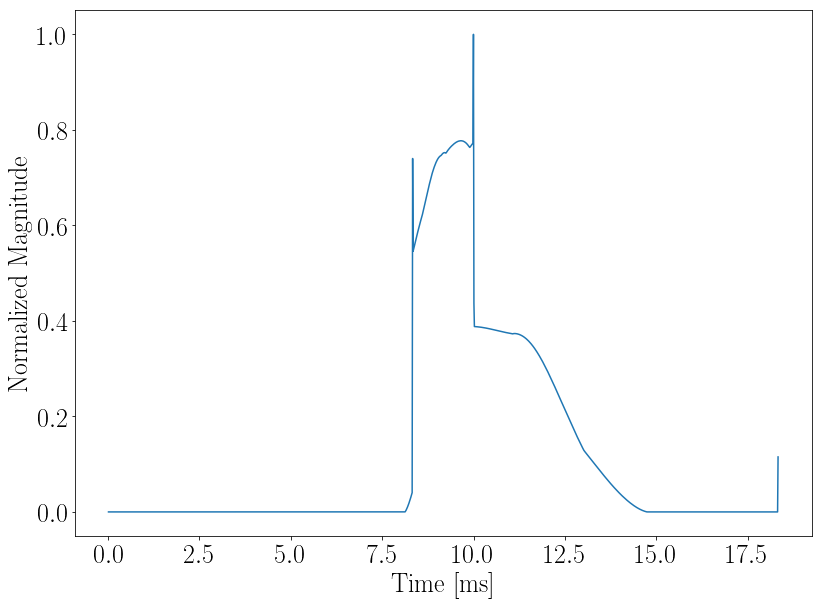

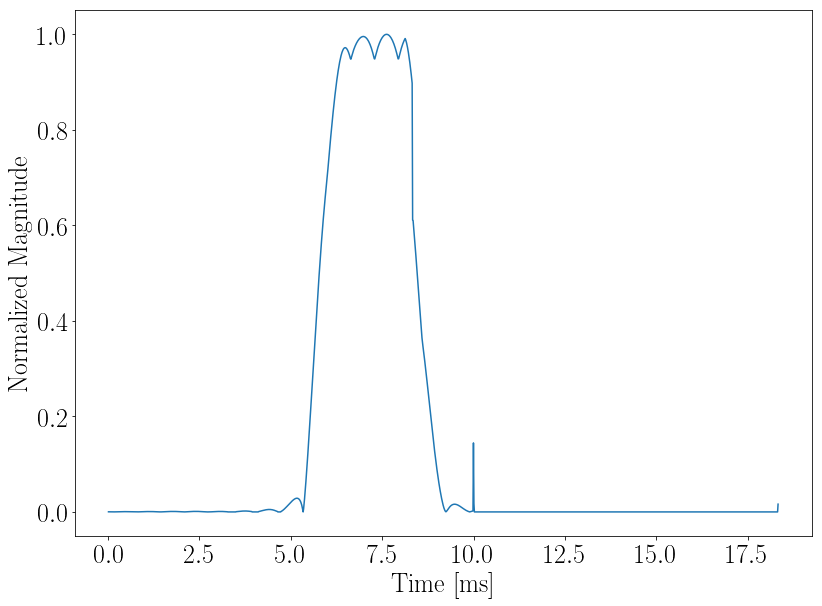

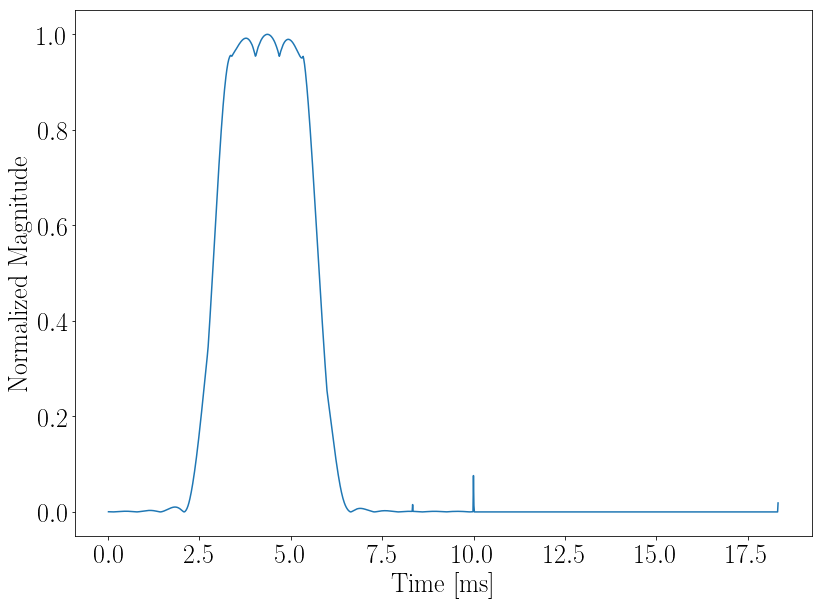

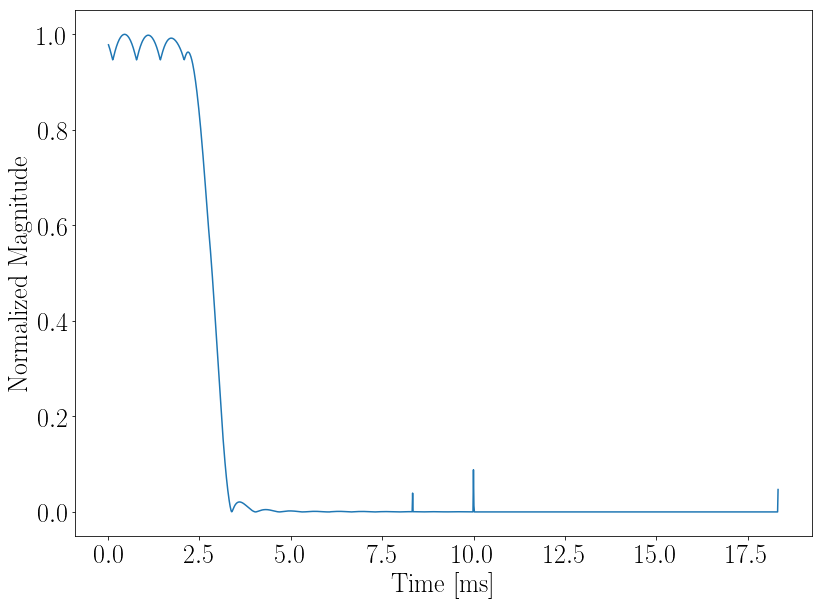

In [40]:
for i in range(H.shape[0]):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(t*1e3, H[i,:]/np.max(H[i,:]))
    ax.set_xlabel('Time [ms]')
    ax.set_ylabel('Normalized Magnitude')
    fig.tight_layout()
    saveFig(fig, figPath, ''.join(['act_', exp_name, beta_loss, str(i)]), save_fig=save_fig)
    plt.show()

# Original signals

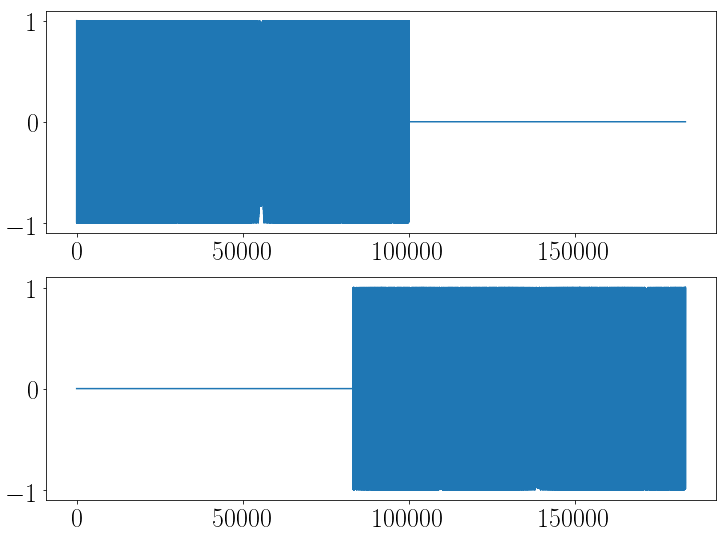

In [23]:
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(signal1)
plt.subplot(2, 1, 2)
plt.plot(signal2)
plt.show()

# Mixed Signal

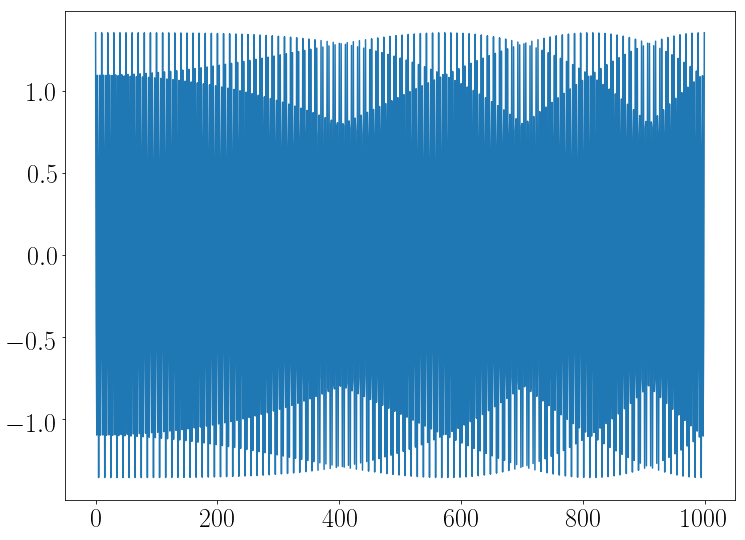

In [24]:
plt.figure()
plt.plot(data[:1000])
plt.show()

# Reconstructed Signals

In [25]:
phase = np.angle(Zxx)
dataHat = []
for i in range(numberOfSources):
    x = np.outer(W[:,i],H[i,:])
    x = x*np.exp(1j*phase)
    _, y = istft(x, fs=fs, nperseg=nperseg, nfft=nfft, input_onesided=True, boundary=False)
    dataHat.append(y)

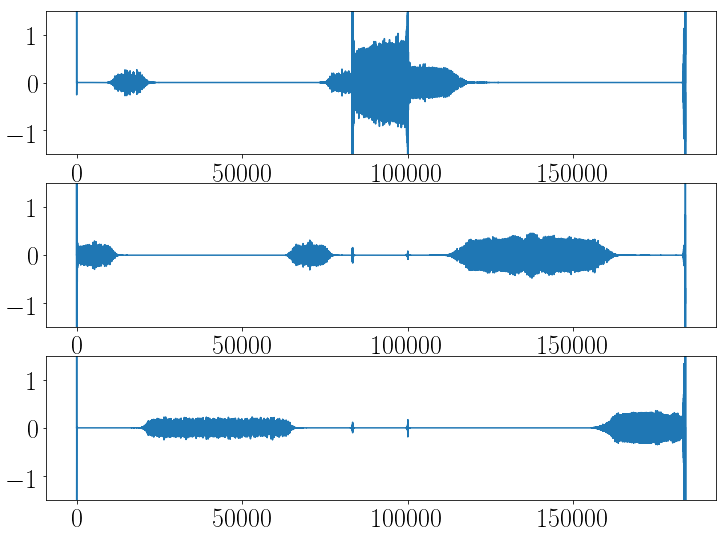

In [26]:
plt.figure()
for j, i in enumerate(dataHat):
    plt.subplot(numberOfSources, 1, j+1)
    plt.ylim(-1.5, 1.5)
    plt.plot(i)
plt.show()

# Saving log file

In [27]:
import json

In [28]:
log_path = './log/'
if not os.path.exists(log_path):
    os.makedirs(log_path)
params = model.get_params()
params['nfft'] = nfft
params['nperseg'] = nperseg
params = json.dumps(params)
if save_fig:
    with open(''.join([log_path, exp_name, beta_loss, '.p']), 'w') as file:
         file.write(params)